In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
root_dir = Path('airbus-ship-detection')
print(list(root_dir.iterdir()))

[WindowsPath('airbus-ship-detection/sample_submission_v2.csv'), WindowsPath('airbus-ship-detection/test_v2'), WindowsPath('airbus-ship-detection/train_ship_segmentations_v2.csv'), WindowsPath('airbus-ship-detection/train_v2')]


In [3]:
train_dir = root_dir / "train_v2"
test_dir = root_dir / "test_v2"
print(f"Files in train dir: {len(list(train_dir.iterdir()))}\nFiles in test dir: {len(list(test_dir.iterdir()))}")

Files in train dir: 192556
Files in test dir: 15606


In [4]:
def contains_only_photos(directory):
    photo_extensions = ['.jpg', '.jpeg', '.png']
    for file in directory.iterdir():
        if file.is_file() and file.suffix.lower() not in photo_extensions:
            return False
    return True

train_contains_only_photos = contains_only_photos(train_dir)
test_contains_only_photos = contains_only_photos(test_dir)
print(f"Train directory contains only photos: {train_contains_only_photos}")
print(f"Test directory contains only photos: {test_contains_only_photos}")

Train directory contains only photos: True
Test directory contains only photos: True


In [5]:
from PIL import Image

def check_image_resolution(directory):
    resolutions = []
    for file in directory.iterdir():
        if file.is_file():
            try:
                image = Image.open(file)
                width, height = image.size
                resolutions.append((width, height))
            except:
                print(f"Error reading image: {file.name}")

    resolutions_df = pd.DataFrame(resolutions, columns=["ImageWidth", "ImageHeight"])
    print(resolutions_df["ImageHeight"].value_counts().to_string())
    print(resolutions_df["ImageWidth"].value_counts().to_string())
    
print("Train directory:")
check_image_resolution(train_dir)

print("\nTest directory:")
check_image_resolution(test_dir)

Train directory:
ImageHeight
768    192556
ImageWidth
768    192556

Test directory:
ImageHeight
768    15606
ImageWidth
768    15606


In [6]:
train_csv_path = root_dir / "train_ship_segmentations_v2.csv"

train_df = pd.read_csv(train_csv_path, index_col='ImageId')
print(f"Shape with duplicates: {train_df.shape}")

train_df = train_df[~train_df.index.duplicated(keep='first')]
print(f"Shape without duplicates: {train_df.shape} (the same amount we have in train dir)")

train_df.head()

Shape with duplicates: (231723, 1)
Shape without duplicates: (192556, 1) (the same amount we have in train dir)


,EncodedPixels
ImageId,
00003e153.jpg,NaN
0001124c7.jpg,NaN
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
0001b1832.jpg,NaN


In [7]:
train_df['file_size_kb'] = train_df.index.map(lambda c_img_id: (train_dir / c_img_id).stat().st_size / 1024)
num_corrupted_images = len(train_df[train_df['file_size_kb'] < 50])

print(f"Number of corrupted images: {num_corrupted_images}")

Number of corrupted images: 1266


Number of images with ships: 42556
Number of images without ships: 150000


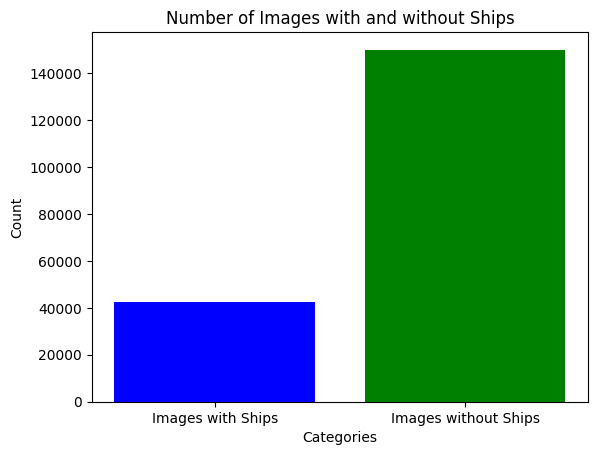

In [8]:
ship_images_count = len(train_df[train_df['EncodedPixels'].notna()])
print(f"Number of images with ships: {ship_images_count}")

no_ship_images_count = len(train_df[train_df['EncodedPixels'].isna()])
print(f"Number of images without ships: {no_ship_images_count}")

categories = ['Images with Ships', 'Images without Ships']
counts = [ship_images_count, no_ship_images_count]

colors = ['blue', 'green']
plt.bar(categories, counts, color=colors)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Number of Images with and without Ships')
plt.show()

In [22]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if isinstance(mask_rle, float) or mask_rle == 0:
        return np.zeros(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [19]:
masks = pd.read_csv(root_dir / 'train_ship_segmentations_v2.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


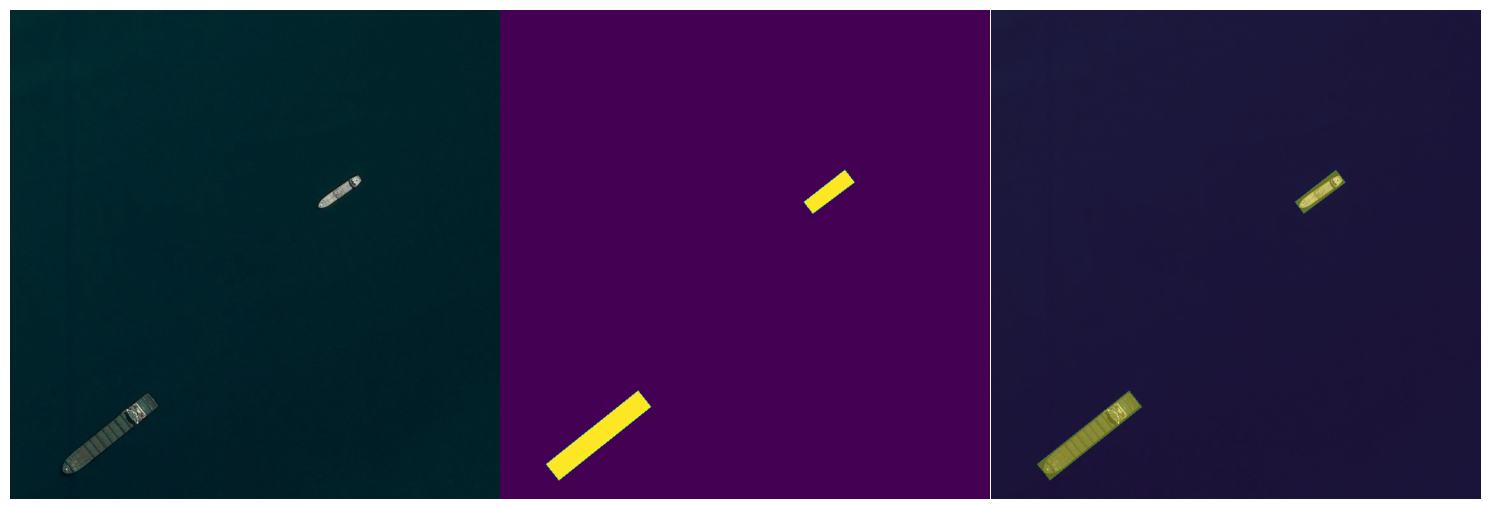

In [23]:
ImageId = '0005d01c8.jpg'
img = Image.open(str(Path(root_dir) / 'train_v2' / ImageId))
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

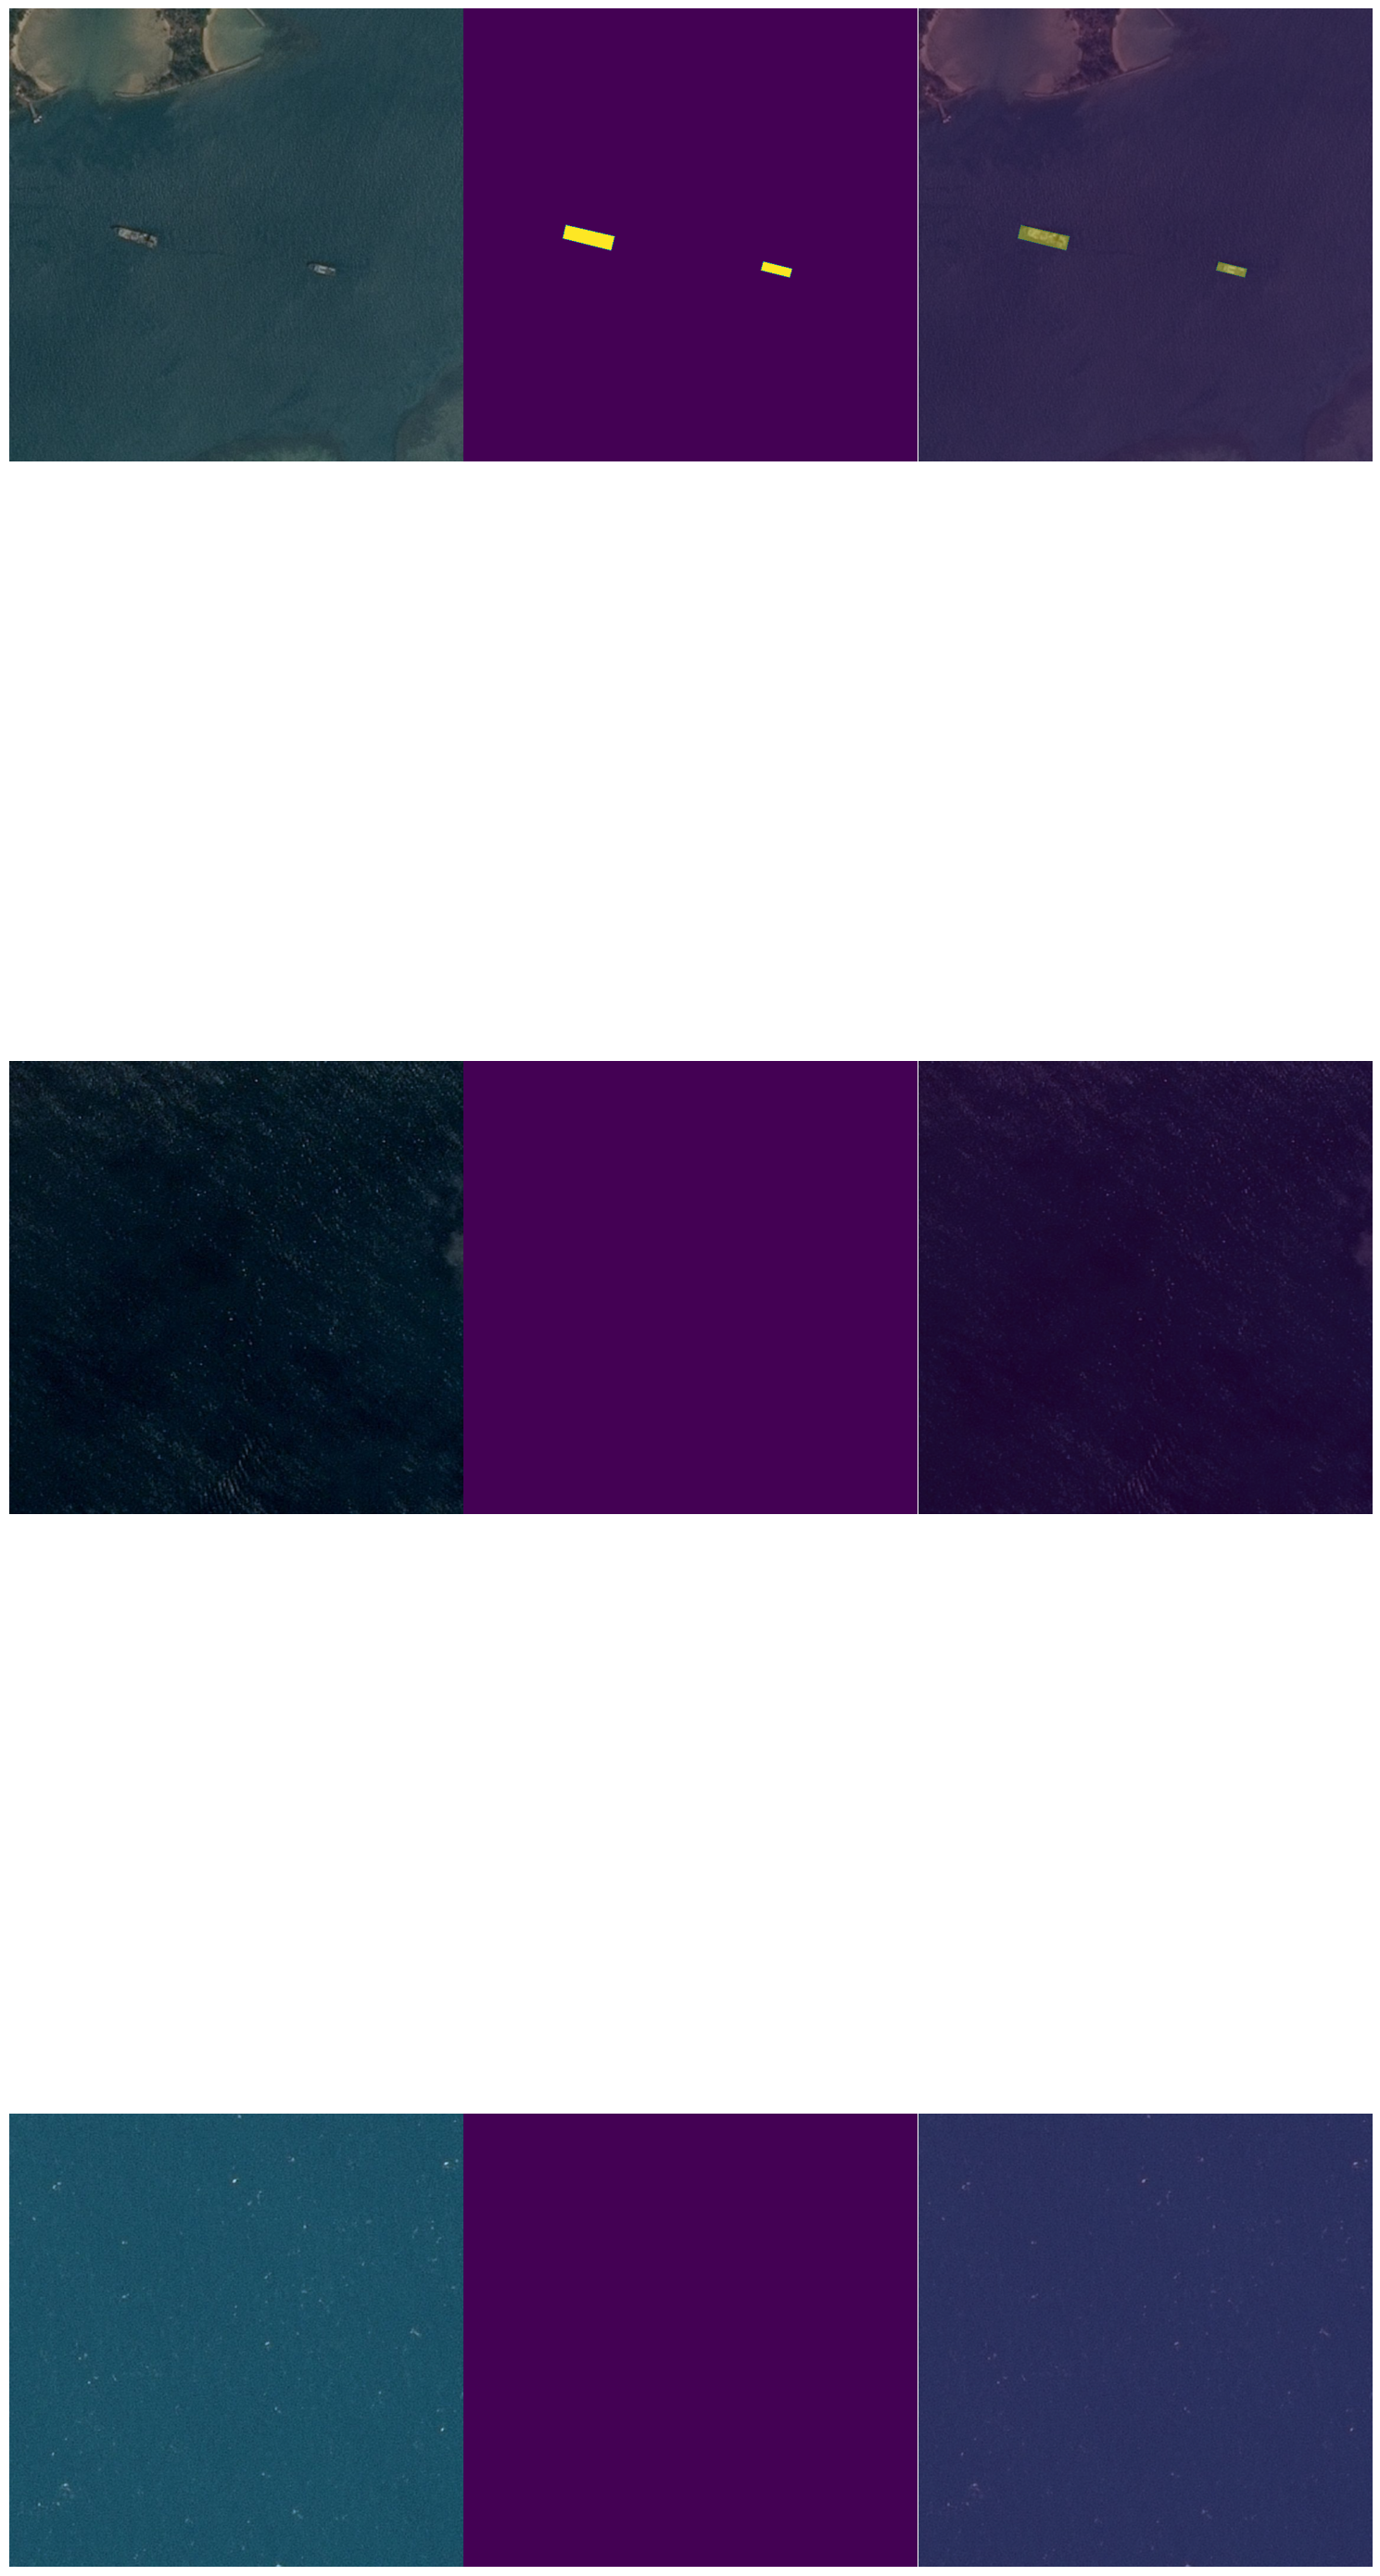

In [34]:
import random

# Get 3 random ImageIds
random_image_ids = random.sample(masks['ImageId'].unique().tolist(), 3)

# Create subplots for the images and masks
fig, axarr = plt.subplots(3, 3, figsize=(15, 40))

for i, image_id in enumerate(random_image_ids):
    # Load the image
    img = Image.open(str(Path(root_dir) / 'train_v2' / image_id))
    
    # Get the masks for the image
    img_masks = masks.loc[masks['ImageId'] == image_id, 'EncodedPixels'].tolist()
    
    # Create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
    
    # Plot the image and mask
    axarr[i, 0].imshow(img)
    axarr[i, 1].imshow(all_masks)
    axarr[i, 2].imshow(img)
    axarr[i, 2].imshow(all_masks, alpha=0.4)
    
    # Turn off axis labels
    axarr[i, 0].axis('off')
    axarr[i, 1].axis('off')
    axarr[i, 2].axis('off')

# Adjust subplot spacing
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()